# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Imports

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocessor
from keras_hist_graph import plot_history
from sklearn.metrics import confusion_matrix
import itertools

from utils import load_images, plot_accuracy_and_loss, plot_smoothed_acc_and_loss, extract_features

Using TensorFlow backend.


In [2]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (50,50))
    plt.figure(figsize = (15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

In [3]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Parameters

In [4]:
train_dir = 'dogs_299/train/'
validation_dir = 'dogs_299/validation/'
test_dir = 'dogs_299/test/'

STD_SIZE = (299, 299)
BATCH_SIZE = 20
ENVIRONNEMENT = 'local'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

# 2 breeds

## Data Preparation

In [5]:
classes = ['Chihuahua', 'Japanese_spaniel']

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 236 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 51 images belonging to 2 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel']


# Model

In [6]:
conv_base = InceptionV3(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [7]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [8]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(8, 8, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(8, 8, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(8, 8, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 8 * 8 * 2048))
validation_features = np.reshape(validation_features, (-1, 8 * 8 * 2048))
test_features = np.reshape(test_features, (-1, 8 * 8 * 2048))

In [9]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_inceptV3_2_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_inceptV3_2_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 236 samples, validate on 50 samples
Epoch 1/1000
 - 1s - loss: 0.1660 - acc: 0.9195 - val_loss: 0.0051 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.00508, saving model to tl_freeze_conv_base_inceptV3_2_breeds
Epoch 2/1000
 - 1s - loss: 0.0051 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.00508 to 0.00273, saving model to tl_freeze_conv_base_inceptV3_2_breeds
Epoch 3/1000
 - 1s - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.00273 to 0.00194, saving model to tl_freeze_conv_base_inceptV3_2_breeds
Epoch 4/1000
 - 1s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000

Epoch 00004: val_loss improved from 0.00194 to 0.00117, saving model to tl_freeze_conv_base_inceptV3_2_breeds
Epoch 5/1000
 - 1s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000

Epoch 00005: val_loss improved from 0.00117 to 0.00104, saving model to tl_freeze_conv_ba

## Results

In [10]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

51/51 [==============================] - 0s 1ms/step


[3.55905905926906e-05, 1.0]

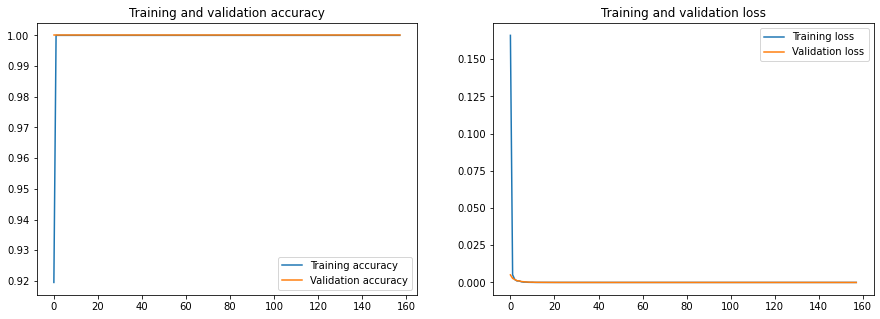

In [11]:
plot_accuracy_and_loss(history)

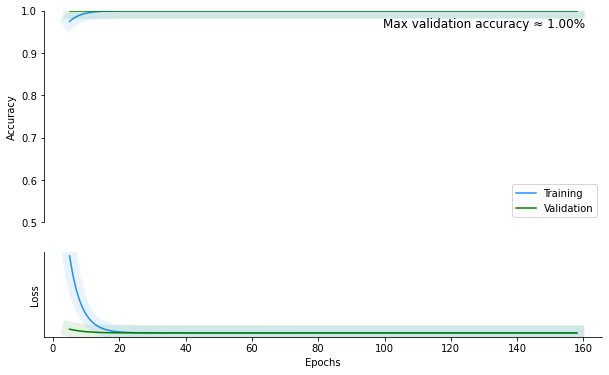

In [12]:
plot_history(history,xkcd=False)

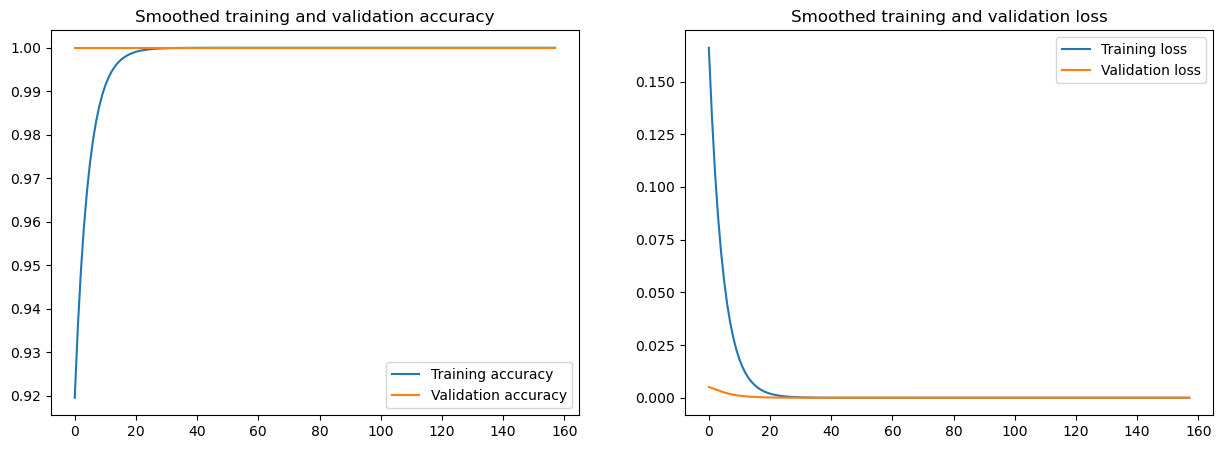

In [13]:
plot_smoothed_acc_and_loss(history, 0.8)

# 3 breeds

## Data preparation

In [14]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 412 images belonging to 3 classes.
Found 88 images belonging to 3 classes.
Found 89 images belonging to 3 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']


## Model

In [15]:
conv_base = InceptionV3(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [16]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
_______________________________________________________________________________________

In [17]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(8, 8, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(8, 8, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(8, 8, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 8 * 8 * 2048))
validation_features = np.reshape(validation_features, (-1, 8 * 8 * 2048))
test_features = np.reshape(test_features, (-1, 8 * 8 * 2048))

In [18]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_inceptV3_3_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_inceptV3_3_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 412 samples, validate on 88 samples
Epoch 1/1000
 - 1s - loss: 0.2748 - acc: 0.8932 - val_loss: 0.0237 - val_acc: 0.9886

Epoch 00001: val_loss improved from inf to 0.02368, saving model to tl_freeze_conv_base_inceptV3_3_breeds
Epoch 2/1000
 - 1s - loss: 0.0119 - acc: 0.9976 - val_loss: 0.0072 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.02368 to 0.00721, saving model to tl_freeze_conv_base_inceptV3_3_breeds
Epoch 3/1000
 - 1s - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.00721 to 0.00474, saving model to tl_freeze_conv_base_inceptV3_3_breeds
Epoch 4/1000
 - 1s - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 1.0000

Epoch 00004: val_loss improved from 0.00474 to 0.00372, saving model to tl_freeze_conv_base_inceptV3_3_breeds
Epoch 5/1000
 - 1s - loss: 7.1108e-04 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000

Epoch 00005: val_loss improved from 0.00372 to 0.00302, saving model to tl_freeze_con

## Results

In [19]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

89/89 [==============================] - 0s 1ms/step


[0.012159461061017875, 0.9887640476226807]

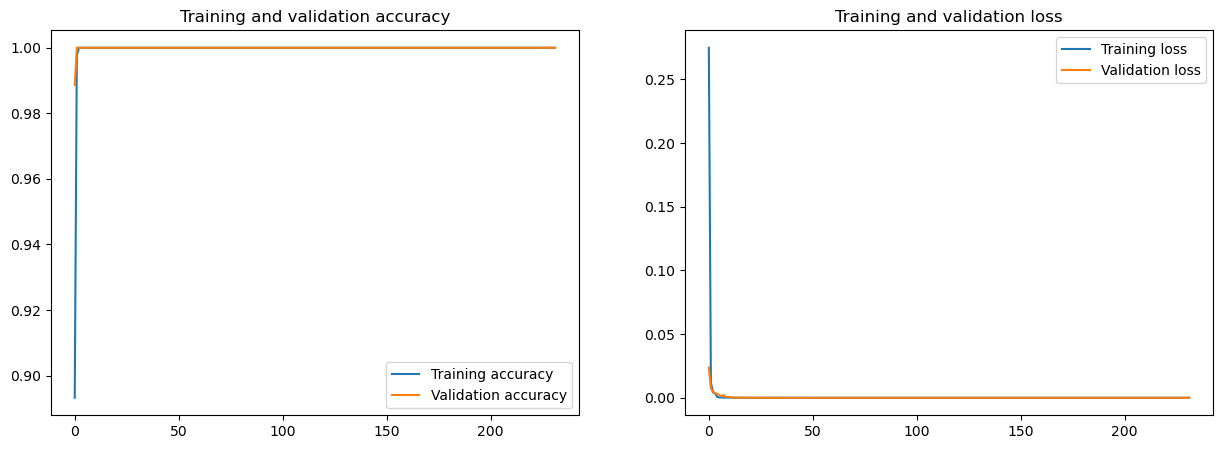

In [20]:
plot_accuracy_and_loss(history)

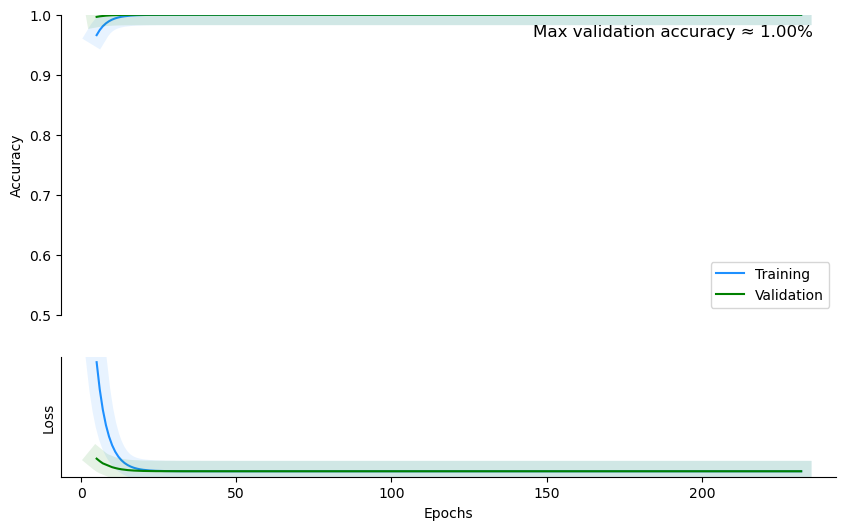

In [21]:
plot_history(history,xkcd=False)

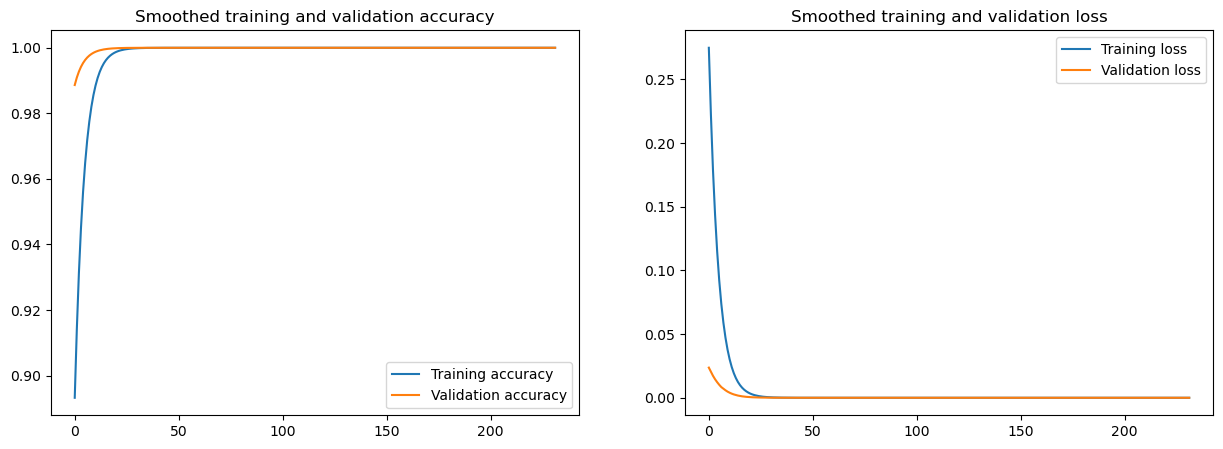

In [22]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

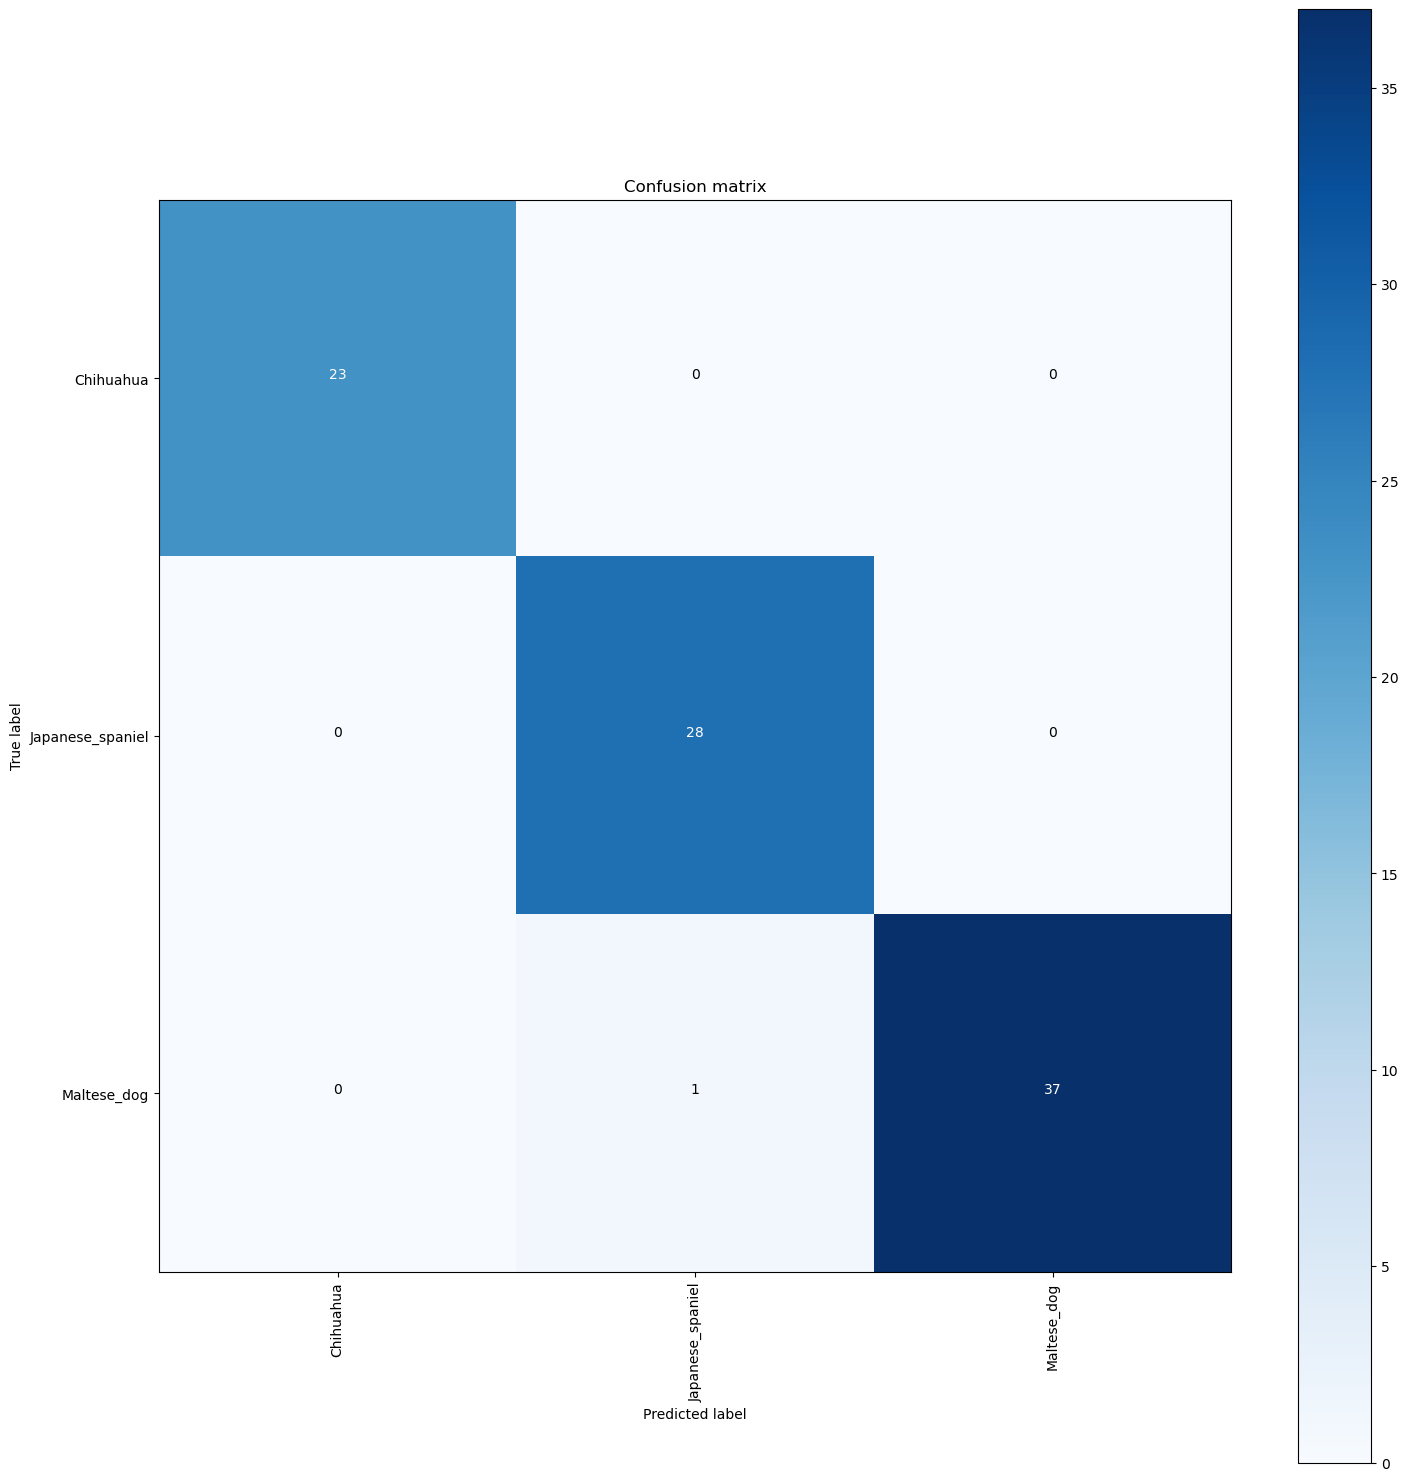

In [23]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()

# 5 breeds

## Data preparation

In [24]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 666 images belonging to 5 classes.
Found 143 images belonging to 5 classes.
Found 143 images belonging to 5 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']


## Model

In [25]:
conv_base = InceptionV3(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [26]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 149, 149, 32) 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 149, 149, 32) 0           batch_normalization_189[0][0]    
_______________________________________________________________________________________

In [27]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(8, 8, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(8, 8, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(8, 8, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 8 * 8 * 2048))
validation_features = np.reshape(validation_features, (-1, 8 * 8 * 2048))
test_features = np.reshape(test_features, (-1, 8 * 8 * 2048))

In [28]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_inceptV3_5_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_inceptV3_5_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 666 samples, validate on 143 samples
Epoch 1/1000
 - 1s - loss: 0.5535 - acc: 0.8093 - val_loss: 0.1540 - val_acc: 0.9580

Epoch 00001: val_loss improved from inf to 0.15400, saving model to tl_freeze_conv_base_inceptV3_5_breeds
Epoch 2/1000
 - 1s - loss: 0.0946 - acc: 0.9655 - val_loss: 0.1296 - val_acc: 0.9580

Epoch 00002: val_loss improved from 0.15400 to 0.12963, saving model to tl_freeze_conv_base_inceptV3_5_breeds
Epoch 3/1000
 - 1s - loss: 0.0553 - acc: 0.9775 - val_loss: 0.1100 - val_acc: 0.9650

Epoch 00003: val_loss improved from 0.12963 to 0.11004, saving model to tl_freeze_conv_base_inceptV3_5_breeds
Epoch 4/1000
 - 1s - loss: 0.0231 - acc: 0.9940 - val_loss: 0.0755 - val_acc: 0.9790

Epoch 00004: val_loss improved from 0.11004 to 0.07554, saving model to tl_freeze_conv_base_inceptV3_5_breeds
Epoch 5/1000
 - 1s - loss: 0.0143 - acc: 0.9970 - val_loss: 0.0680 - val_acc: 0.9790

Epoch 00005: val_loss improved from 0.07554 to 0.06797, saving model to tl_freeze_conv_b

## Results

In [29]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

143/143 [==============================] - 0s 1ms/step


[0.1507399444813495, 0.9650349617004395]

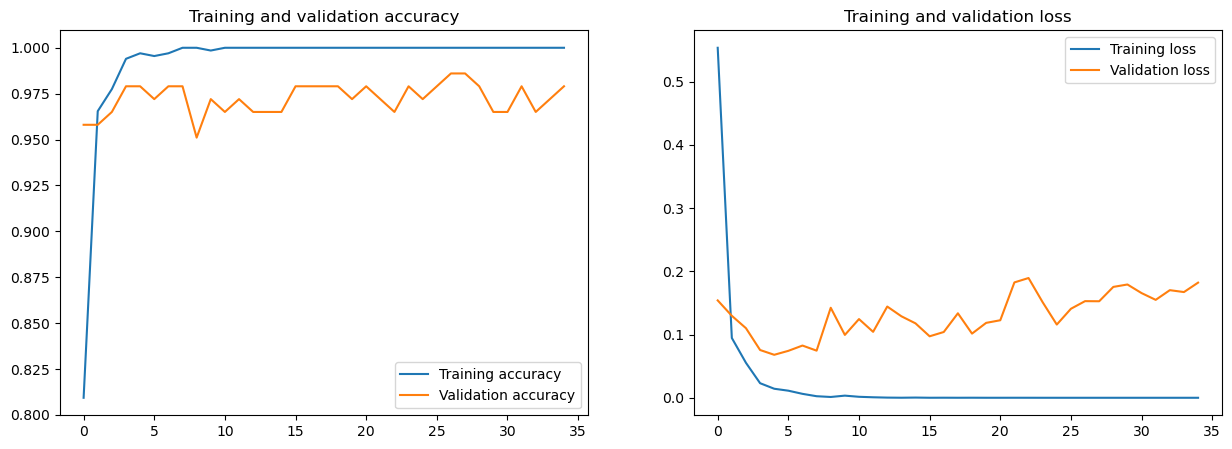

In [30]:
plot_accuracy_and_loss(history)

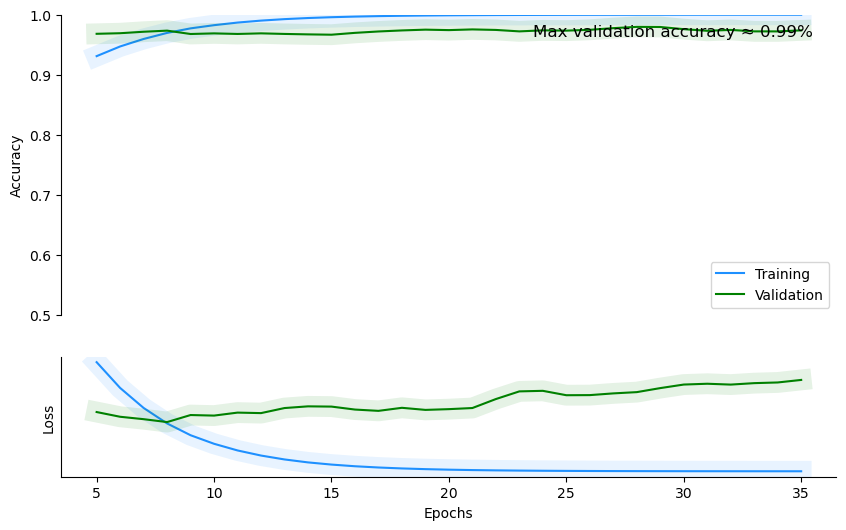

In [31]:
plot_history(history,xkcd=False)

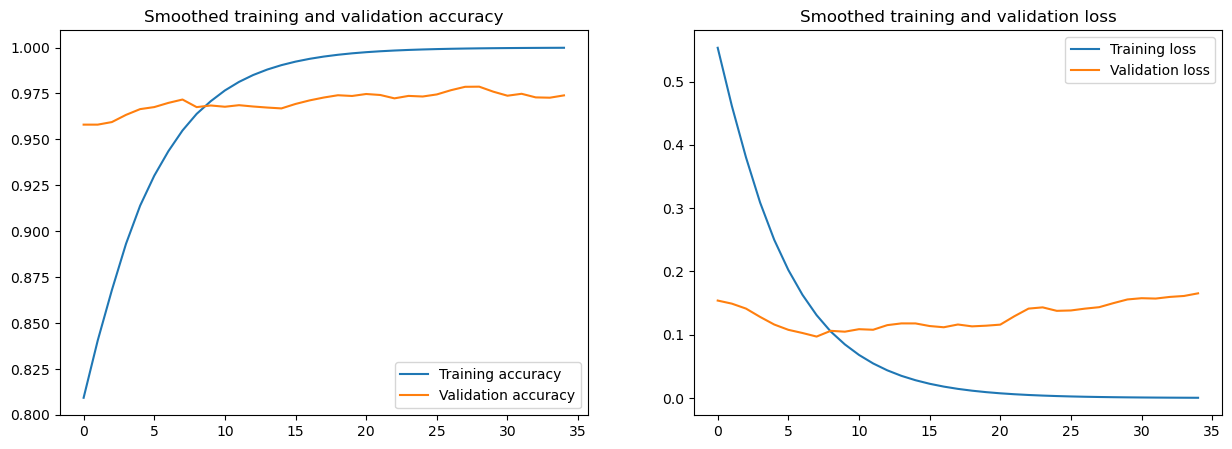

In [32]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

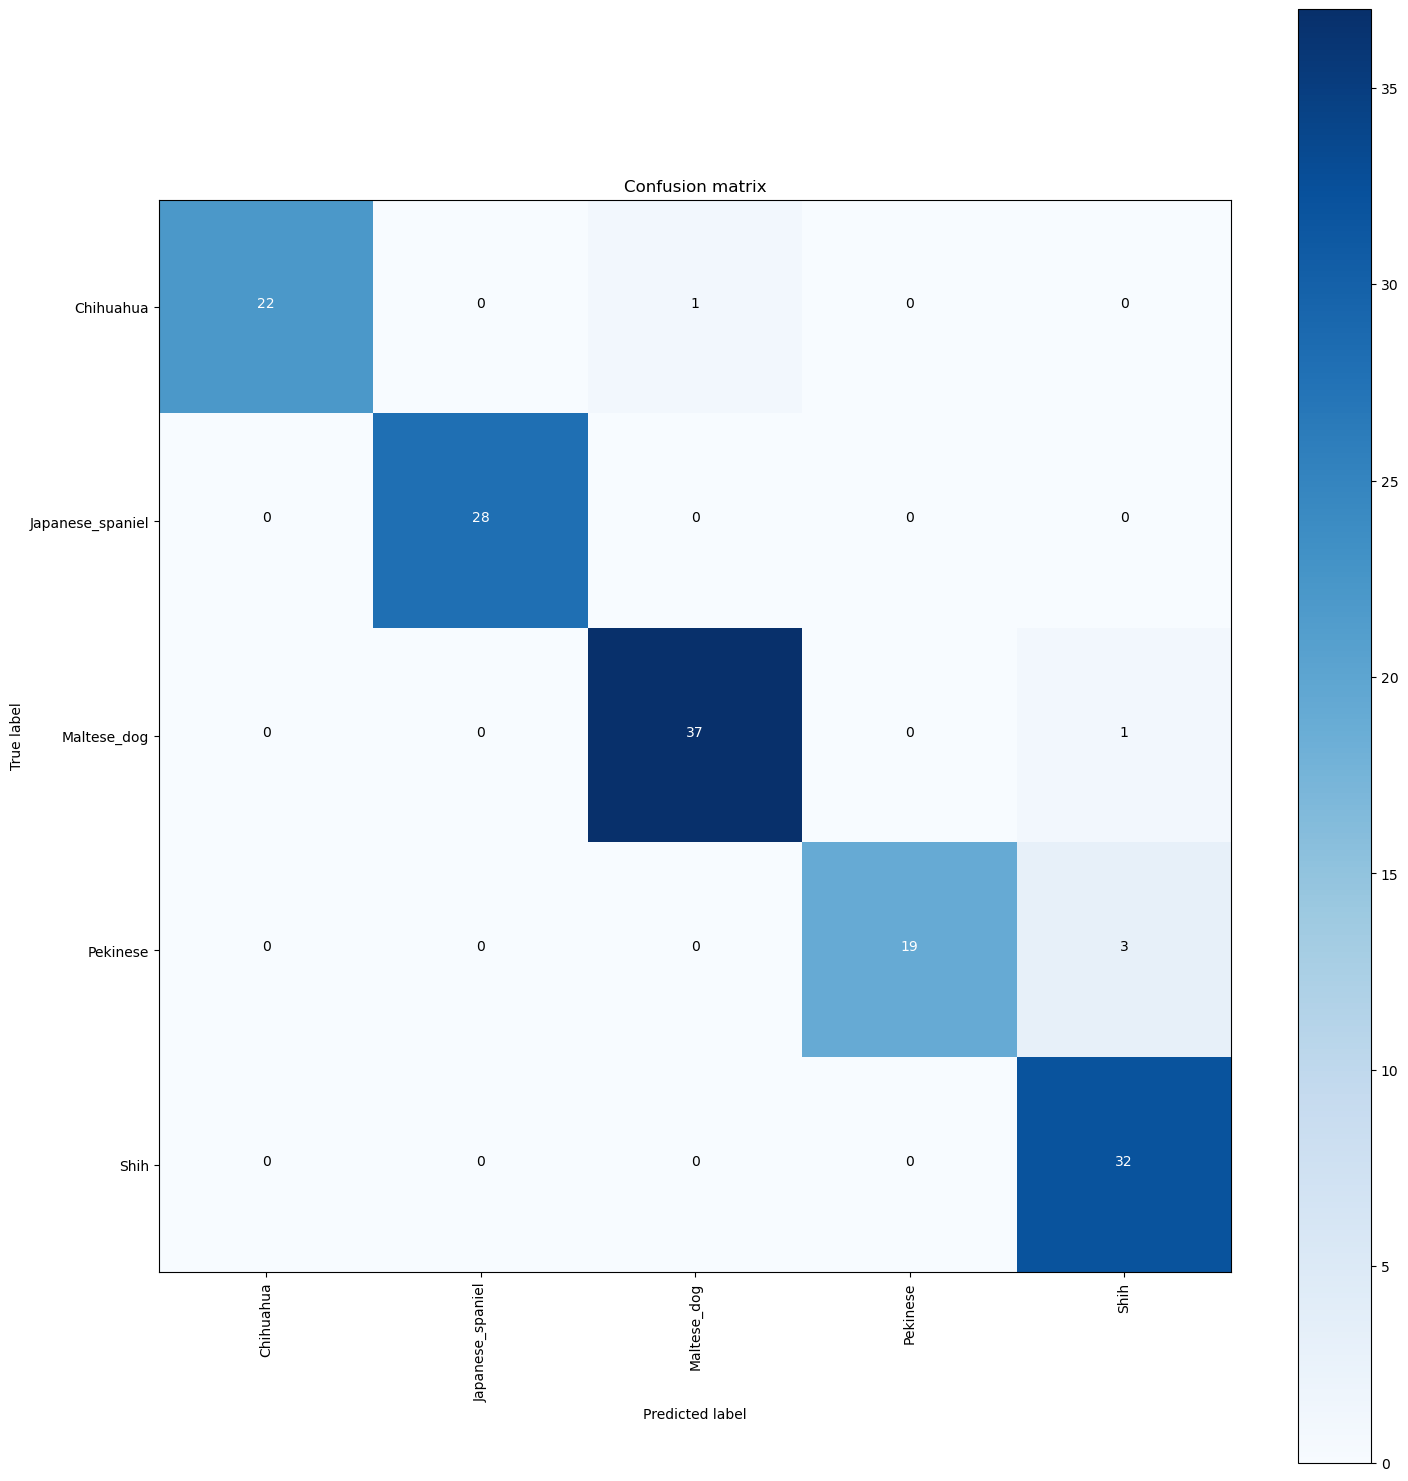

In [33]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()

# 60 breeds

## Data preparation

In [34]:
classes = os.listdir(PATH + train_dir)[:60]

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 7072 images belonging to 60 classes.
Found 1527 images belonging to 60 classes.
Found 1512 images belonging to 60 classes.

Stored classes labels in classes_labels:  ['affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'basenji', 'basset', 'beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'black', 'Blenheim_spaniel', 'bloodhound', 'bluetick', 'Border_collie', 'Border_terrier', 'borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'boxer', 'Brabancon_griffon', 'briard', 'Brittany_spaniel', 'bull_mastiff', 'cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly', 'Dandie_Dinmont', 'dhole', 'dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'flat', 'French_bulldog', 'German_shepherd', 'German_short', 'giant_schnauzer', 'golden_retriever', 'Gordon_setter', 'Greater_Swiss_Mountain_do

## Model

In [35]:
conv_base = InceptionV3(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [36]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_283 (Conv2D)             (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_283 (BatchN (None, 149, 149, 32) 96          conv2d_283[0][0]                 
__________________________________________________________________________________________________
activation_283 (Activation)     (None, 149, 149, 32) 0           batch_normalization_283[0][0]    
_______________________________________________________________________________________

In [37]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(8, 8, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(8, 8, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(8, 8, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 8 * 8 * 2048))
validation_features = np.reshape(validation_features, (-1, 8 * 8 * 2048))
test_features = np.reshape(test_features, (-1, 8 * 8 * 2048))

In [38]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_inceptV3_60_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_inceptV3_60_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 7072 samples, validate on 1527 samples
Epoch 1/1000
 - 15s - loss: 1.3393 - acc: 0.7308 - val_loss: 0.4323 - val_acc: 0.9005

Epoch 00001: val_loss improved from inf to 0.43233, saving model to tl_freeze_conv_base_inceptV3_60_breeds
Epoch 2/1000
 - 16s - loss: 0.5456 - acc: 0.8821 - val_loss: 0.4924 - val_acc: 0.9083

Epoch 00002: val_loss did not improve from 0.43233
Epoch 3/1000
 - 15s - loss: 0.3996 - acc: 0.9186 - val_loss: 0.3689 - val_acc: 0.9319

Epoch 00003: val_loss improved from 0.43233 to 0.36893, saving model to tl_freeze_conv_base_inceptV3_60_breeds
Epoch 4/1000
 - 15s - loss: 0.3232 - acc: 0.9358 - val_loss: 0.4685 - val_acc: 0.9273

Epoch 00004: val_loss did not improve from 0.36893
Epoch 5/1000
 - 15s - loss: 0.2272 - acc: 0.9531 - val_loss: 0.5388 - val_acc: 0.9267

Epoch 00005: val_loss did not improve from 0.36893
Epoch 6/1000
 - 15s - loss: 0.1943 - acc: 0.9603 - val_loss: 0.4951 - val_acc: 0.9286

Epoch 00006: val_loss did not improve from 0.36893
Epoch 7/

## Results

In [39]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

1512/1512 [==============================] - 8s 5ms/step


[0.5336445021965398, 0.9113756418228149]

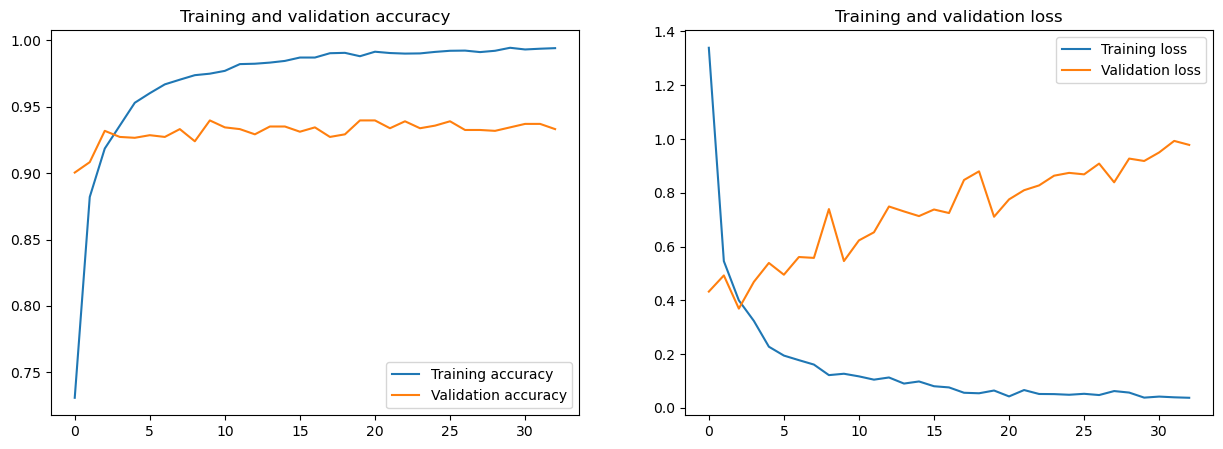

In [40]:
plot_accuracy_and_loss(history)

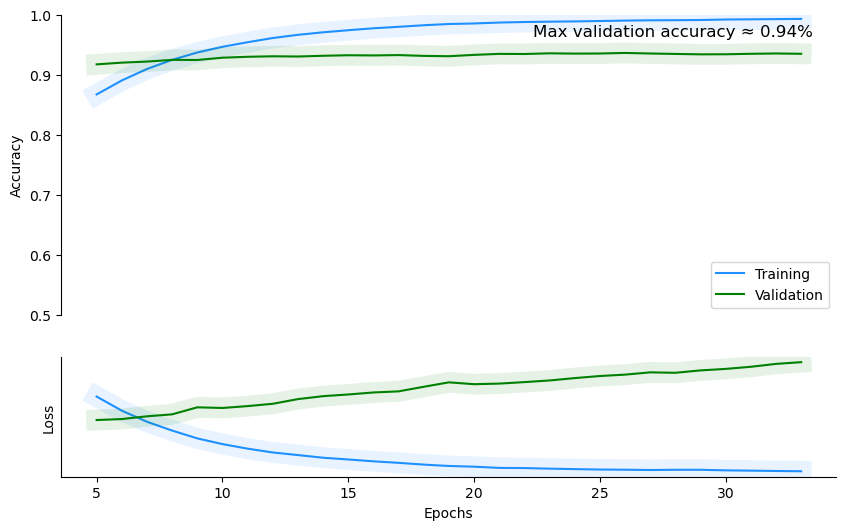

In [41]:
plot_history(history,xkcd=False)

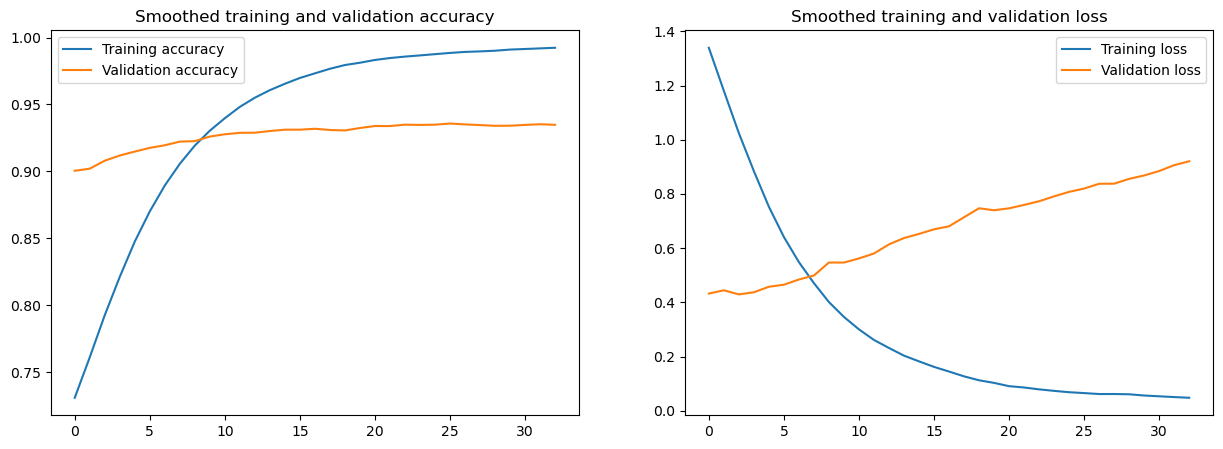

In [42]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

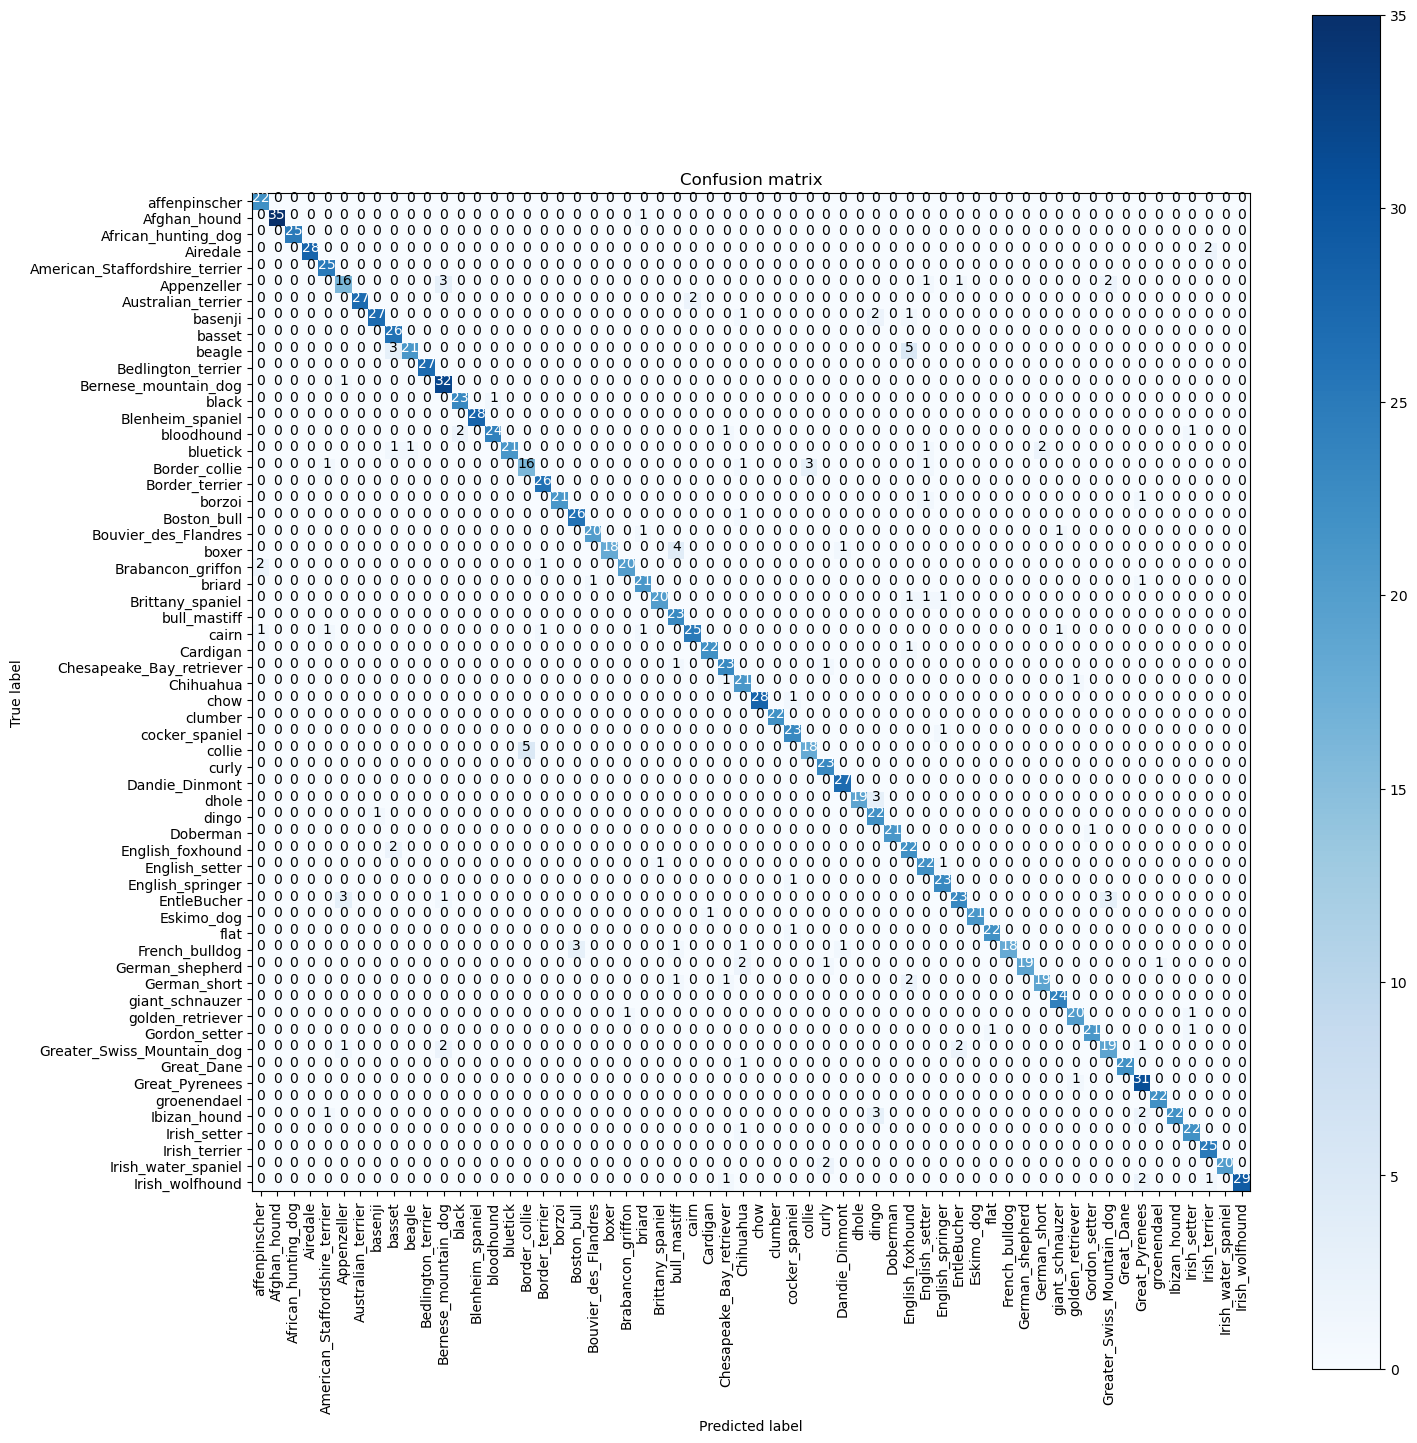

In [43]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()

# 120 breeds

## Data preparation

In [5]:
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 14397 images belonging to 120 classes.
Found 3099 images belonging to 120 classes.
Found 3084 images belonging to 120 classes.

Stored classes labels in classes_labels:  ['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', '

# Model

In [6]:
conv_base = InceptionV3(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [7]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [8]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(8, 8, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(8, 8, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(8, 8, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 8 * 8 * 2048))
validation_features = np.reshape(validation_features, (-1, 8 * 8 * 2048))
test_features = np.reshape(test_features, (-1, 8 * 8 * 2048))

In [9]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_inceptV3_120_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_inceptV3_120_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 14397 samples, validate on 3099 samples
Epoch 1/1000
 - 89s - loss: 1.6662 - acc: 0.6222 - val_loss: 0.4403 - val_acc: 0.8690

Epoch 00001: val_loss improved from inf to 0.44032, saving model to tl_freeze_conv_base_inceptV3_120_breeds
Epoch 2/1000
 - 113s - loss: 0.4554 - acc: 0.8705 - val_loss: 0.4118 - val_acc: 0.8716

Epoch 00002: val_loss improved from 0.44032 to 0.41183, saving model to tl_freeze_conv_base_inceptV3_120_breeds
Epoch 3/1000
 - 88s - loss: 0.2731 - acc: 0.9157 - val_loss: 0.4102 - val_acc: 0.8813

Epoch 00003: val_loss improved from 0.41183 to 0.41015, saving model to tl_freeze_conv_base_inceptV3_120_breeds
Epoch 4/1000
 - 94s - loss: 0.1848 - acc: 0.9437 - val_loss: 0.4020 - val_acc: 0.8880

Epoch 00004: val_loss improved from 0.41015 to 0.40199, saving model to tl_freeze_conv_base_inceptV3_120_breeds
Epoch 5/1000
 - 98s - loss: 0.1258 - acc: 0.9612 - val_loss: 0.4273 - val_acc: 0.8825

Epoch 00005: val_loss did not improve from 0.40199
Epoch 6/1000
 - 91s 

## Results

In [10]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

3084/3084 [==============================] - 22s 7ms/step


[0.4174654174441455, 0.8832684755325317]

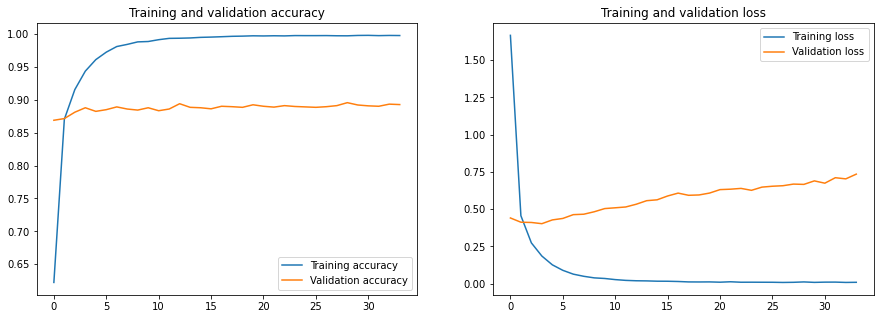

In [11]:
plot_accuracy_and_loss(history)

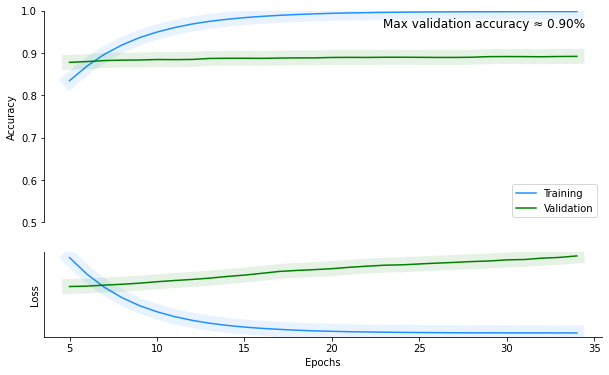

In [12]:
plot_history(history,xkcd=False)

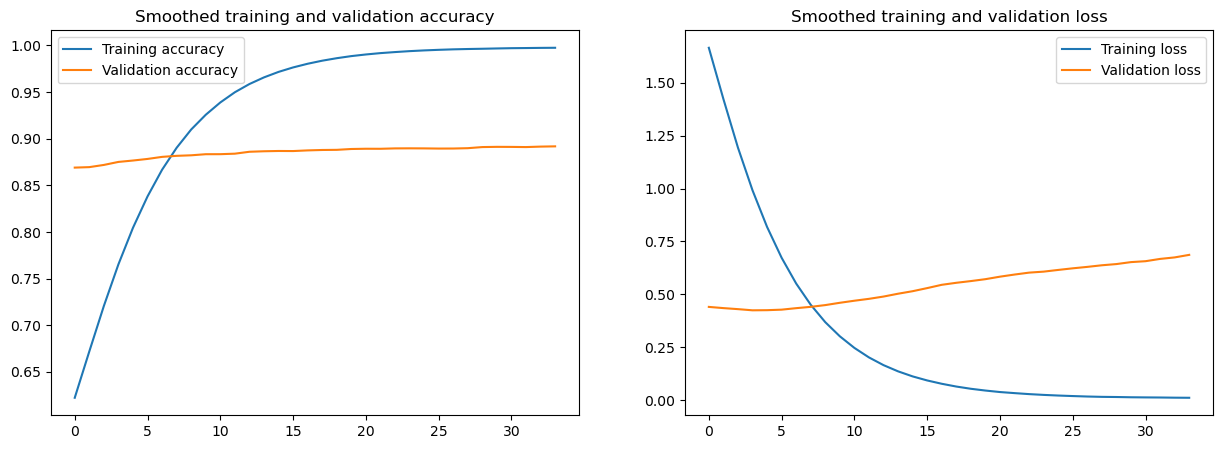

In [13]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

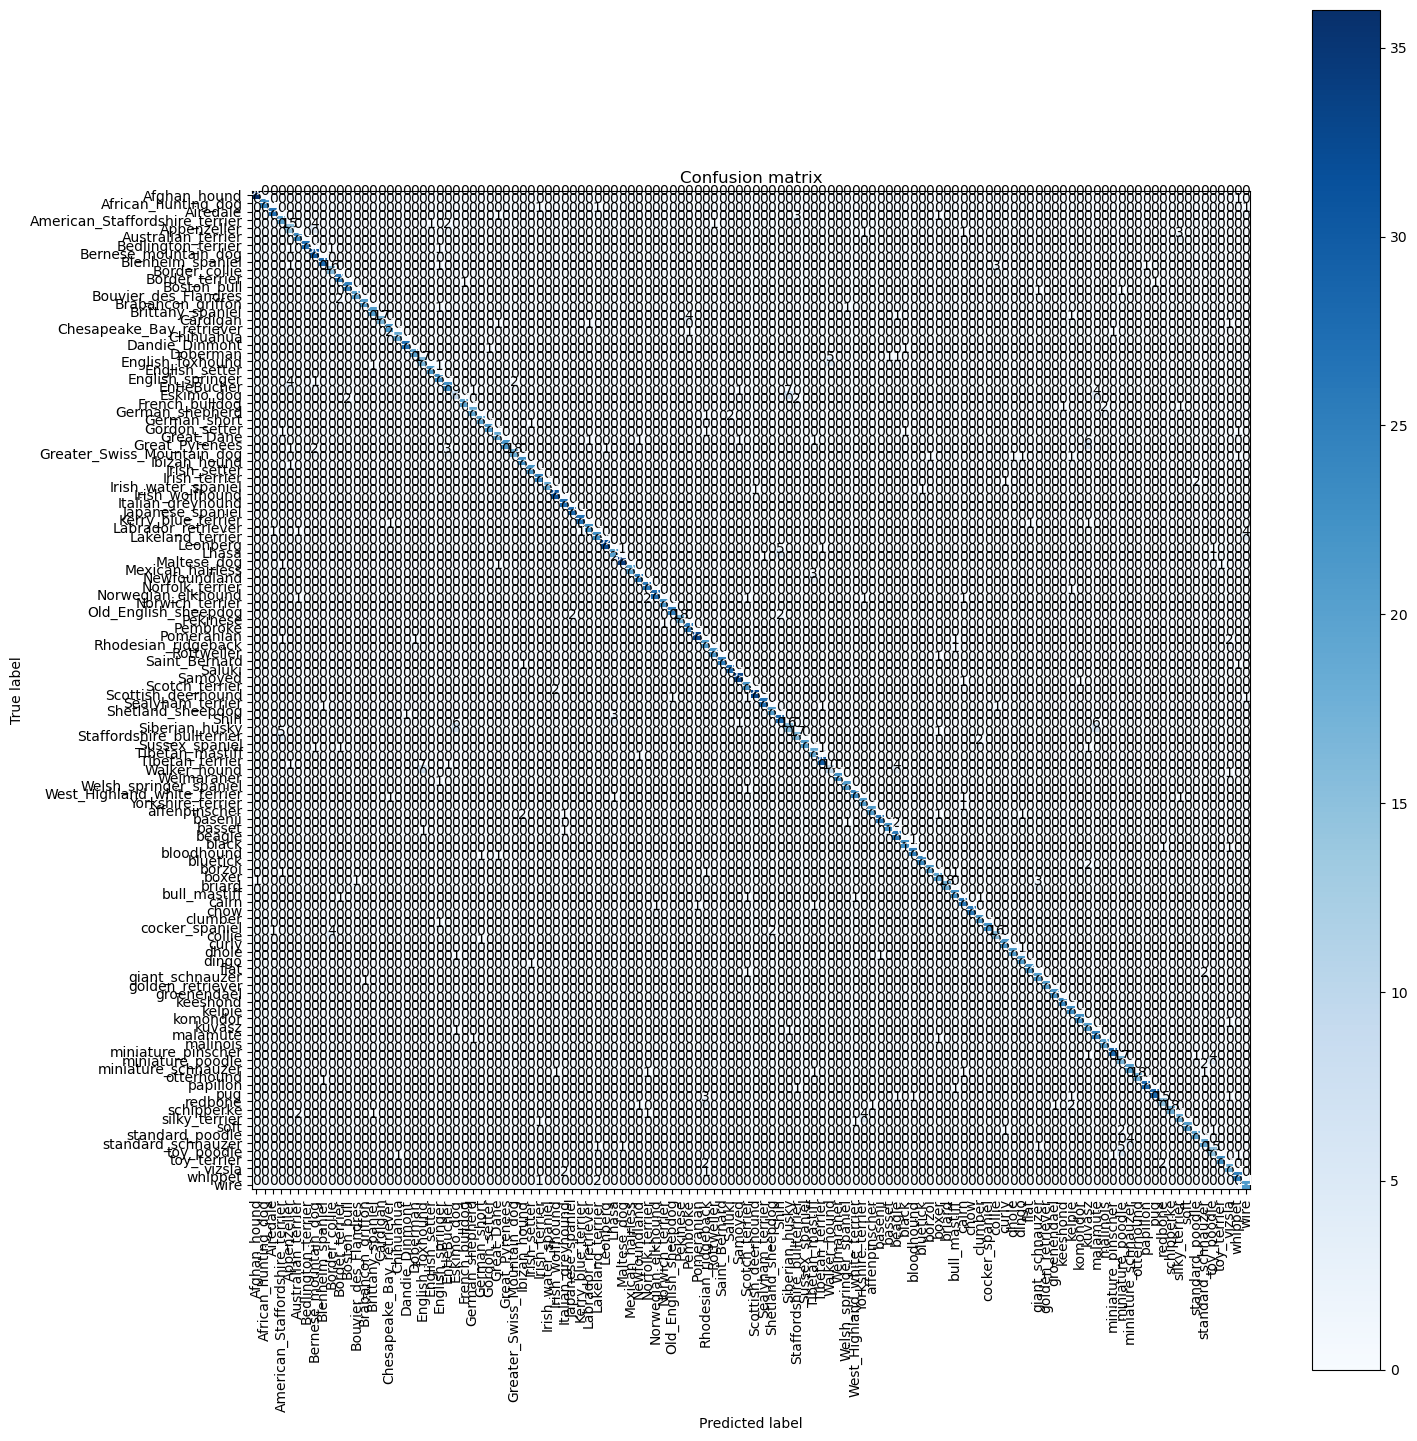

In [14]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()